##### Grading Feedback Cell

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Vidushi Mishra <vmishr01@syr.edu>
- Faculty Assistant: Pranav Kottoli Radhakrishna <pkottoli@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include descriptinve title and axis labels.  Plot legends shall be included where possible.  Unless stated otherwise, plots can be made using any Python plotting package.  It is understood that spark data structures must be converted to something like numpy or pandas prior to making plots.  All required mathematical operations, filtering, selection, etc., required by a homework question shall be performed in spark prior to converting to numpy or pandas.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- We reserve the right to take points off for operations that are extremely inefficient or "heavy weight".  This is a big data class and extremely inefficient operations make a big difference when scaling up to large data sets.  For example, the spark dataframe collect() method is a very heavy weight operation and should not be used unless it there is a real need for it.  An example where collect() might be needed is to get ready to make a plot after filtering a spark dataframe.
- import * is not allowed because it is considered a very bad coding practice and in some cases can result in a significant delay (which slows down the grading process) in loading imports.  For example, the statement `from sympy import *` is not allowed.  You must import the specific packages that you need.
- If you perform databricks specific operations, you MUST protect those operations in an if statement by calling the is_databricks() function provided in all homework assignments.  For example, if you use dbutils (databricks utilities), only run dbutils commands if is_databricks() returns true.  Runtime errors created in the grading environment by not protecting databricks specific commands in an if statement will result in a runtime error points deduction. 
- The graders reserve the right to deduct points for subjective things we see with your code.  For example, if we ask you to create a pandas data frame to display values from an investigation and you hard code the values, we will take points off for that.  This is only one of many different things we could find in reviewing your code.  In general, write your code like you are submitting it for a code peer review in industry.  
- Level of effort is part of our subjective grading.  Oftentimes there is a large disparity between the level of effort between students who are trying learn, and students who are trying to do the minimum possible to check off an assignment requirement.  For example, in cases where we ask for a more open ended investigation, some students put in significant effort and some students do the minimum possible to meet requirements.  In these cases, we may take points off for students who did not put in much effort as compared to students who did put in a lot of effort.  We feel that the students who did a better job deserve a better grade.  We reserve the right to invoke level of effort grading at any time.
- Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.
- Unless code is provided which reads data files, __you must use the get_training_filename function povided below to read data files."  Runtime errors encountered while grading caused by students not using get_training_filename will result in a minimum of half points off for the problem in question.__

In [3]:
# Do not delete or change this cell

# grading import statements
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "dbfs:/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Diamonds Data
If you have ever had an interest in diamonds then this homework is for you!  This homework assignment will use a diamonds dataset to explore spark pipelines, linear regression, feature transformation, model scoring, inference, and feature selection.

The diamonds.csv data set contains 10 columns:
- carat: Carat weight of the diamond
- cut: Describes cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal
- color: Color of the diamond, with D being the best and J the worst
- clarity: How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, etc.  See this web site for an exhaustive ranking of [clarity](https://4cs.gia.edu/en-us/diamond-clarity/?gclid=Cj0KCQjwnqH7BRDdARIsACTSAduMoc2KQbXkO94BxCfBNC5X8YyjAYcFpWThKQMW46cQj_3p0pZ0o84aAuagEALw_wcB).  The web site has a nice sliding scale you can drag to see the relationship between clarity grades.
- depth: depth % - The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
- table: table% -  The width of the diamond's table expressed as a percentage of its average diameter
- price: The price of the diamond
- x: Length (mm)
- y: Width (mm)
- z: Height (mm)

# Notes:
- In this assignment __and moving forward__, we won't explicitly tell you to split data into train / test / validation sets.  It's up to you as a data scientist to know when and how to create appropriate splits for your models.  If we say to use dataframe X to train and test a model, it's up to you to know the best practicies as covered in lecture.  When you start working in industry, nobody is going to tell you when and how to split your data.  This will not be mentioned in future assignments.
- __You must use get_training_filename to generate the file name before reading the file.__  In addition, you must use get_training_filename to generate the file name before reading data files for all future assignments as well (see instructions).  We will not explicitly mention this in future homework assignments (except in the instructions).

# Question 0 (0 pts)
Please provide the following the data so we can verify your github information
- Your Name:
- Your github user name:
- Your SU email address:

Name: Fangzhou Yuan
Github User Name: fyuan04
SU Email: fyuan04@syr.edu

# Question 1 (10 pts)
Read the diamonds.csv file into a spark data frame named `diamonds_df`.

In [9]:
# Your code here
diamonds_df = spark.read.format("csv").option("header", "true").load(get_training_filename("diamonds.csv"))

In [10]:
# Grading Cell - do not modify
display(diamonds_df.toPandas().head())

_c0,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58,334,4.2,4.23,2.63
5,0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75


##### Grading Feedback Cell

# Question 2 (10 pts)
Investigate the diamond data.  Create a pair plot on the real data columns which sumarizes the data. In addition to the pair plot, use a spark dataframe built in function to provide a statistical summary of the data.  Provide a written summary of the pair plot and statistical summary observations.

In [13]:
import pandas as pd
df = diamonds_df.toPandas()
df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']] = df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']].apply(pd.to_numeric)

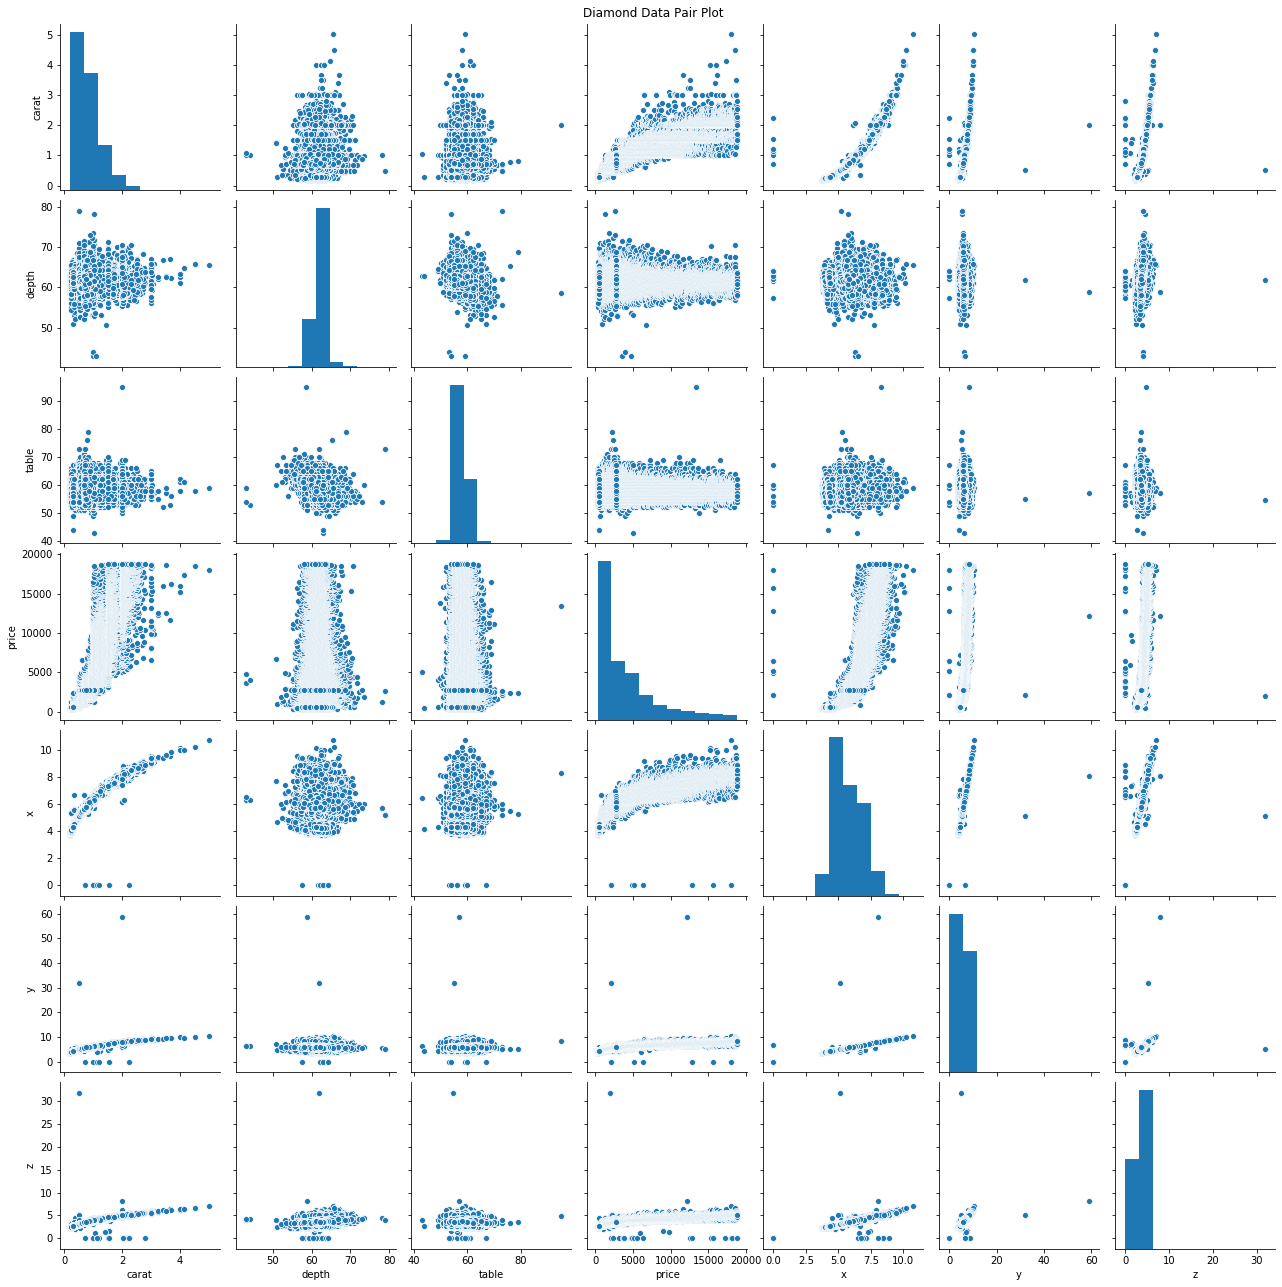

In [14]:
# Your code here
import seaborn as sns
ax = sns.pairplot(df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']])
ax.fig.suptitle("Diamond Data Pair Plot", y=1.01)

In [15]:
diamonds_df.describe().toPandas()

,summary,_c0,carat,cut,color,clarity,depth,table,price,x,y,z
0,count,53940,53940,53940,53940,53940,53940,53940,53940,53940,53940,53940
1,mean,26970.5,0.7979397478679852,None,None,None,61.74940489432624,57.45718390804603,3932.799721913237,5.731157211716609,5.734525954764462,3.5387337782723316
2,stddev,15571.281096942537,0.4740112444054196,None,None,None,1.4326213188336525,2.2344905628213247,3989.439738146397,1.1217607467924915,1.1421346741235616,0.7056988469499883
3,min,1,0.2,Fair,D,I1,43,43,1000,0,0,0
4,max,9999,5.01,Very Good,J,VVS2,79,95,9999,9.86,9.94,8.06


##### Grading Feedback Cell

Your summary explanation here:

For the pairplot, I always look at the diagonal first, beacuse these plots are distributions of all the numeric columns. "carat" and "price" columns are obviously right-skewed and there might be a positive correlation between them. "depth", "table", and "x" columns are normal distribution alike to different extents. Then looking at the scatter plots, I am more interested in the ones that show observable positive/negative correlations. Not suprisingly, "carat" is positively correlated to "x", "y", and "z", which define the volumn of a diamond, and normally a diamond with larger volumn is heavier. Besides, the "price" column is positively correlated to "carat", "x", "y", and "z", which agrees with our common sense: heavier and larger diamonds tend to be more expensive.

The summary statistics produced by the describe function provide us some additional information about the data.Something worth noticing is that some numerical columns have very different range of values. For example, the "carat" column varies in a range of 0.2-5.01, while the depth can go from 43 to 79. So if we are going to build a model, we may need to consider standarlizing the columns to make sure that we are not giving more weights to numeric columns with a larger range.

##### Grading Feedback Cell

# Question 3 (20 pts)
There are one or more columns of data in diamonds_df which are not in an appropriate format for performing linear regression.  Perform feature engineering on all columns which are not in a format which is ready for use in a linear regression model.  Create a new data frame named `diamonds_df_xformed` which contains the same number of columns and the same column names as diamonds_df.  Transform diamonds_df such that diamonds_df_xformed is ready to feed into a linear regression model for training.  diamonds_df_xformed Shall contain new feature engineered columns that can be directly used in linear regression.  Encapsulate your feature engineering / transformation code into a spark pipeline named feature_engineering_pipe.  Describe in words all columns on which you performed feature engineering.  Include the specific transformation algorighm used, and your reasoning for using the chosen algorithm.  We expect to see an explanation for each and every column on which you perform feature engineering.

In [20]:
# your code here
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexerModel
from pyspark.ml import Pipeline

cut_pipe = StringIndexerModel.from_labels(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
                                    inputCol="cut",
                                    outputCol="cut_1")
color_pipe = StringIndexerModel.from_labels(['D', 'E', 'F', 'G', 'H','I','J'],
                                    inputCol="color",
                                    outputCol="color_1")
clarity_pipe = StringIndexerModel.from_labels(['I1', 'SI2', 'SI1', 'VS2', 'VS1','VVS2','VVS1','IF'],
                                    inputCol="clarity",
                                    outputCol="clarity_1")



In [21]:
test_df = diamonds_df
pipeline = Pipeline(stages = [cut_pipe, color_pipe, clarity_pipe])
diamonds_df_xformed = pipeline.fit(test_df).transform(test_df)


In [22]:
diamonds_df_xformed
columns_to_drop = ['_c0', 'cut','clarity','color']
diamonds_df_xformed = diamonds_df_xformed.drop(*columns_to_drop)
diamonds_df_xformed = diamonds_df_xformed.withColumnRenamed("cut_1", "cut").withColumnRenamed("color_1", "color").withColumnRenamed("clarity_1", "clarity")

In [23]:
# Grading Cell do not modify
display(diamonds_df_xformed.toPandas().head())

carat,depth,table,price,x,y,z,cut,color,clarity
0.23,61.5,55,326,3.95,3.98,2.43,4.0,1.0,1.0
0.21,59.8,61,326,3.89,3.84,2.31,3.0,1.0,2.0
0.23,56.9,65,327,4.05,4.07,2.31,1.0,1.0,4.0
0.29,62.4,58,334,4.2,4.23,2.63,3.0,5.0,3.0
0.31,63.3,58,335,4.34,4.35,2.75,1.0,6.0,1.0


##### Grading Feedback Cell

Your explanation here:

For linear regression, we would like all the columns to be numeric. The first block of my code tells exactly how I transformed the string columns: "cut", "color", and "clerity", to numeric columns. I used the StringIndexerModel function for all three columns. for "cut" and "clarity", I ordered the labels from negative to positive. So larger numeric values indicate a better condition of a diamond. For color, I do not have any domain knowledger on which color(s) may have higher values, so I followed an alphabetic order.

##### Grading Feedback Cell

# Question 4 (10 pts)
Create a new pipeline named `diamond_pipe`.  diamond_pipe Shall contain a spark linear regression object (at a minimum) with default parameters.  Train and test diamond_pipe on the diamonds_df_xformed data frame using price as the target.  Use a spark evaluator object to score the linear regression model using mean squared error.  Print the train and test mean squared error results.

In [28]:
# your code here
from pyspark.sql import functions as fn
from pyspark.ml import feature
from pyspark.ml import classification

for col in diamonds_df_xformed.columns:
  diamonds_df_xformed = diamonds_df_xformed.withColumn(
    col,
    fn.col(col).cast("double")
  )
#diamonds_df.withColumn("carat",rawdata["price"].cast(DoubleType()).alias("price")

In [29]:
train, test = diamonds_df_xformed.randomSplit([0.8, 0.2], 0)

In [30]:
from pyspark.ml import regression, evaluation
from pyspark.ml.evaluation import RegressionEvaluator

diamond_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity'],
                                        outputCol='features'),
                  regression.LinearRegression(labelCol='price', featuresCol='features')])

diamond_pipe_fitted = diamond_pipe.fit(train)
evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="price",metricName="mse")
print(evaluator.evaluate(diamond_pipe_fitted.transform(test)))

1453761.4414297452

##### Grading Feedback Cell

# Question 5 (10 pts)
Repeat question 4 only this time score the model using 3-fold cross validation using an empty parameter grid. Print the resulting score from 3 fold cross validation.  Briefly explain how 3 fold cross validation is different than the scoring technique used in question 4 above.

In [33]:
# your code here
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder().build()

crossval = CrossValidator(estimator=diamond_pipe, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)

cv_fitted = crossval.fit(train)
print(evaluator.evaluate(cv_fitted.transform(diamonds_df_xformed)))

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
1480459.2354593566

##### Grading Feedback Cell

Your explanation here:

For question 4, I split the data into train and test with a ratio of 80%/20%. The model was fitted on the train data and try to predict the price for the test data. So the "mse" is calculated based on the model prediction on the test data. For the cross validation method, instead of predict the price of the test data, I proformed transform on the entire dataset, because 3 fold cross validation would randomly select 2/3 of the data for training and 1/3 for testing for each fold. Thus, I am having a different "mse" output from question 5.

##### Grading Feedback Cell

# Question 6 (10 pts)
In this question you will use inference to determine the most important predictor order.  Create a new pipeline named inference_pipe which encapsulates a standard scalar and a linear regression object (at a minimum).  After fitting the pipe, create a pandas data frame from the fitted regression model coefficients named `coefficients_df`.  coefficients_df Shall have 2 columns named `coefficient` and `value`.  The coefficient column shall contain the coefficient names and the value column shall contain the regression model coefficient absolute values.  Provide a written explanation of what the results mean.  Include a description of why we are using the standard scalar object, and how the standard scalar object allows us to perform the specified inference.

In [38]:
# your code here

va = feature.VectorAssembler(inputCols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity'], outputCol='features')
sc = feature.StandardScaler(withMean=True, inputCol='features')
lr = regression.LinearRegression(labelCol='price', featuresCol='features')
inference_pipe = Pipeline(stages=[va, sc, lr])

inference_pipe_fitted = inference_pipe.fit(train)

coef_values = [stage.coefficients for stage in inference_pipe_fitted.stages if hasattr(stage, "coefficients")]
coefficient = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity']

In [39]:
value = []
for i in coef_values:
  for j in i:
    value.append(abs(j))

coefficients_df = pd.DataFrame(list(zip(coefficient, value)), columns =['coefficient', 'value'])

In [40]:
# Grading cell do not modify
display(coefficients_df)

coefficient,value
carat,10617.092256324331
depth,73.61694368090643
table,27.144690890531912
x,786.8076773073329
y,38.31852921826513
z,100.9683872340435
cut,122.03502334881067
color,323.5752360290241
clarity,500.4944848670637


##### Grading Feedback Cell

Your explanation here: 

The coefficients for each variable indicates that for a unit change of a colum, how much the price would go up/down if every other column stays the same. The larger the value is, the more influencial a predictor is.

We are standardizing the columns because as what we had found from the pair plot, there is multicolinearity among predictors. If we do not standardize the columns, the multicolinearity can lead to inaccurate coefficients due to the weights assigned and make it more difficult to choose the correct model.

With the standardization done, we can directly compare the coefficient value of each predictor. The largest value is given by"carat", so this column should be ranked the highest in terms of the feature importance. Following the same logic, the smallest coefficient value indicates a column is least important in the linear regression model built.

##### Grading Feedback Cell

# Question 7 (20 pts)
Partially implement the forward stepwise selection algorithm 6.2 in ISLR. The code from this question is a partial implementation because the function specified essentially completes a single iteration of algorithm 6.2 per call. Create a function named `find_best_pred` that takes 3 arguments: A list of starting column names for the initial model, a list of column names to test for improvement, and the target column name.  Use MSE as the improvement metric.  The return value is the name of the column that provides the largest MSE improvement.  If no improvement in MSE is detected, return the string 'Null'.  Starting with the starting columns, the find_best_pred function shall return the col name that produces the largest improvement in MSE.  Check for error conditions and return the 'Null' string if there is an error in the input data.  To make it more fun, we plan on running secret tests that include errors when we grade.  Assume that you can use the diamonds_df_xformed as a global variable. You are free to decompose this problem into as many sub functions as you want as long as the main function is named find_best_pred.

In [45]:
# your code here
col_names =  diamonds_df_xformed.columns
num_predictors = len(diamonds_df_xformed.columns) - 1

def find_best_pred(start_cols, test_cols, target_col):
  # inputs error checking
  if (len(test_cols) == 0 or len(test_cols) > num_predictors or len(start_cols) >= num_predictors):
    return("Null")
  
  if len(start_cols) != 0:
    for col in start_cols:
      if col not in col_names:
        return("Null")
  
  for col in test_cols:
    if col not in col_names:
        return("Null")
      
  if target_col != "price":
    return("Null")
  
  
  if len(start_cols) != 0:
    diamond_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=start_cols, outputCol='features'),
                   regression.LinearRegression(labelCol=target_col, featuresCol='features')])
    diamond_pipe_fitted = diamond_pipe.fit(diamonds_df_xformed)
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target_col,metricName="mse")
    start_MSE = evaluator.evaluate(diamond_pipe_fitted.transform(diamonds_df_xformed))
    
    MSE_diff_list = []
    for col in test_cols:
      diamond_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=start_cols+[col], outputCol='features'),
                   regression.LinearRegression(labelCol=target_col, featuresCol='features')])
      diamond_pipe_fitted = diamond_pipe.fit(diamonds_df_xformed)
      evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target_col,metricName="mse")
      temp_MSE = evaluator.evaluate(diamond_pipe_fitted.transform(diamonds_df_xformed))
      MSE_diff_list.append(temp_MSE - start_MSE)
    
    if min(MSE_diff_list) >= 0:
      return("Null")
    col_index = MSE_diff_list.index(min(MSE_diff_list))
    return(test_cols[col_index])
                                  
    
  else:
    MSE_list = []
    for col in test_cols:
      diamond_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=[col], outputCol='features'),
                                      regression.LinearRegression(labelCol=target_col, featuresCol='features')])
      diamond_pipe_fitted = diamond_pipe.fit(diamonds_df_xformed)
      evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target_col,metricName="mse")
      temp_MSE = evaluator.evaluate(diamond_pipe_fitted.transform(diamonds_df_xformed))
      MSE_list.append(temp_MSE)
    
    col_index = MSE_list.index(min(MSE_list))
    return(test_cols[col_index])
  

In [46]:
# Grading cell - do not modify
print(find_best_pred([], ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))
print(find_best_pred(['carat', 'cut'], ['color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))


carat
clarity

##### Grading Feedback Cell

# Question 8 (10 pts)
Finish implementing the forward stepwise selection algorithm 6.2 in ISLR.  Question 7 implemented a single iteration of ISLR algorithm 6.2.  The purpose of this question is to create a driver function that will iteratively call the find_best_pred function defined in question 7 to create the complete ordered list of best predictors.  Create a new function named `get_stepwise_pred_list` which iteratively calls find_best_pred to build an ordered list of the best stepwise features. Terminate building the list if find_best_pred returns Null or you run out of predictors to test - whichever comes first.  get_stepwise_pred_list Takes 2 arguments:  A list of all predictors and the dataset target column.   get_stepwise_pred_list Returns a list containing the ordered stepwise features selected by iteratively calling find_best_pred.

In [49]:
# your code here

def get_stepwise_pred_list(predictors, target):
  start_col = []
  stepwise_pred_list = []
  for i in range(len(predictors)):
    stepwise_pred_list.append(find_best_pred(start_col, predictors, target))
    start_col.append(stepwise_pred_list[i])
    predictors.remove(stepwise_pred_list[i])
    
  return(stepwise_pred_list)

In [50]:
# grading cell do not modify
print(get_stepwise_pred_list(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

['carat', 'clarity', 'color', 'x', 'cut', 'depth', 'table', 'y', 'z']

##### Grading Feedback Cell

# Extra Credit (10 pts)
Question 7 creates a function that is specific to the diamonds data set.  The problem with the scheme is that it only works for one data set and it assumes a very specific model.  Being a great data scientist, you realize that the code would be significantly more valuable if it was more flexible.  The right thing to do is extend the functionality of the code to be able to use any pipeline and any data set.  Start by adding a data frame argument to get_stepwise_pred_list.  get_stepwise_pred_list Will then need to pass the data frame to the find_best_pred function.  This solves the problem of being able to operate with any data frame.

There is a bigger problem.  We need a way to build a custom model built specifically for the data frame. Currently, we are building a very specific custom model in the find_best_pred function that is customized for only one data frame - the diamond data frame.  We need to come up with a way to customize the pipeline for any data frame. One solution to this problem is to create a user defined callback function which builds the pipelines. The callback function will take as input arguments a list of feature names to train on, and return a ready to use spark pipeline.  Add the callback function to the get_stepwise_pred_list argument list.  Port the code that builds the pipe which was previously defined in the find_best_pred function to your new user defined callback function.  Now instead of building the pipe in find_best_pred, the find_best_pred function will call the callback function to build the pipe.  With this piece of the puzzle solved, we are a lot closer to having the level of flexibility you would need for a production environment.  Notwithstanding, there are still other problems to solve.  For example, we also need to be able to specify the loss function to use - MSE is not the best loss function for say a logistic regression pipe.  It would also be great if we could encapsulate all of this functionality into a python class.  But to get full credit for this problem, you only need the pipe function callback and to add the dataframe as an argument.  

Your are free to add arguments or change things some from the above description. The above is only a loose guide.  Experiment and have fun. 

Demonstrate your results by executing the updated code using the test from problem 8 above.

In [53]:
# your code here
from pyspark.sql import DataFrame

def find_best_pred_new(df, start_cols, test_cols, target_col):
  # inputs error checking
  if not isinstance(df, DataFrame):
    return("Null")
  
  for col in df.columns:
    df = df.withColumn(
      col,
      fn.col(col).cast("double")
    )
  
  col_names = df.columns
  num_predictors = len(df.columns) - 1
  
  if (len(test_cols) == 0 or len(test_cols) > num_predictors or len(start_cols) >= num_predictors):
    return("Null")
  
  if len(start_cols) != 0:
    for col in start_cols:
      if col not in col_names:
        return("Null")
  
  for col in test_cols:
    if col not in col_names:
        return("Null")
      
  if type(target_col) != str or target_col not in col_names:
    return("Null")
  
  #inputs checked, use pipeline to fit and transform model, find the column with best mse

  #find the original mse
  if len(start_cols) != 0:
    lr_pipe = callback_pipe_fun(start_cols, target_col)
    lr_pipe_fitted = lr_pipe.fit(df)
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target_col,metricName="mse")
    start_MSE = evaluator.evaluate(lr_pipe_fitted.transform(df))
    
  #calculate new mse for each additional column 
    MSE_diff_list = []
    for col in test_cols:
      input_cols = start_cols + [col]
      lr_pipe = callback_pipe_fun(input_cols, target_col)
      lr_pipe_fitted = lr_pipe.fit(df)
      evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target_col,metricName="mse")
      temp_MSE = evaluator.evaluate(lr_pipe_fitted.transform(df))
      MSE_diff_list.append(temp_MSE - start_MSE)
    
    if min(MSE_diff_list) >= 0:
      return("Null")
    col_index = MSE_diff_list.index(min(MSE_diff_list))
    return(test_cols[col_index])
                                  
  else:
    MSE_list = []
    for col in test_cols:
      lr_pipe = callback_pipe_fun([col], target_col)
      lr_pipe_fitted = lr_pipe.fit(df)
      evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target_col,metricName="mse")
      temp_MSE = evaluator.evaluate(lr_pipe_fitted.transform(df))
      MSE_list.append(temp_MSE)
    
    col_index = MSE_list.index(min(MSE_list))
    return(test_cols[col_index])
  
  
#####################################################################################
  
def get_stepwise_pred_list_new(df, predictors, target):
  start_col = []
  stepwise_pred_list = []
  for i in range(len(predictors)):
    stepwise_pred_list.append(find_best_pred_new(df, start_col, predictors, target))
    start_col.append(stepwise_pred_list[i])
    predictors.remove(stepwise_pred_list[i])
    
  return(stepwise_pred_list)

#####################################################################################

def callback_pipe_fun(start_cols, target_col):
  lr_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=start_cols, outputCol='features'),
                                  regression.LinearRegression(labelCol=target_col, featuresCol='features')])
  return(lr_pipe)


In [54]:
print(get_stepwise_pred_list_new(diamonds_df_xformed, ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

['carat', 'clarity', 'color', 'x', 'cut', 'depth', 'table', 'y', 'z']

##### Grading Feedback Cell